# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

According to the dataset description and the accompanying research paper, this data represents **multiple marketing campaigns** conducted by a Portuguese banking institution between May 2008 and November 2010. 

The dataset includes information from **17 campaigns** in total, with the data capturing:
- Information about the **current campaign** (indicated by features like 'campaign', 'duration', 'contact', 'month', 'day_of_week')
- Information about **previous campaigns** (indicated by features like 'pdays', 'previous', and 'poutcome')

The key features that help us understand this:
- **campaign**: number of contacts performed during the current campaign for each client
- **pdays**: number of days since the client was last contacted from a previous campaign (999 means not previously contacted)
- **previous**: number of contacts performed before the current campaign
- **poutcome**: outcome of the previous marketing campaign (failure, nonexistent, or success)

The goal of these campaigns was to get clients to subscribe to a bank term deposit product via telephone contact.

For this phone campaign, an attractive long-term deposit application with good interest rates was offered. Details of each contact like (job, marital status, education, housing and personal loan etc.) was stored as part of the interaction.

Ultimately, the dataset shows that there was 8% success rate with 6499 contacts accepting the Long-term deposit application out of the 79,354 contacts.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer


from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [2]:
marketing_data = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
marketing_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [4]:
marketing_data.shape

(41188, 21)

In [5]:
marketing_data.rename(columns = {'y':'isSubscribed'}, inplace = True)

In [6]:
# Check for missing values (NaN/null)
marketing_data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
isSubscribed      0
dtype: int64

In [7]:
marketing_data.describe(include='all')

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,isSubscribed
count,41188.00000,41188,41188,41188,41188,41188,41188,41188,41188,41188,...,41188.000000,41188.000000,41188.000000,41188,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188
unique,NaN,12,4,8,3,3,3,2,10,5,...,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,2
top,NaN,admin.,married,university.degree,no,yes,no,cellular,may,thu,...,NaN,NaN,NaN,nonexistent,NaN,NaN,NaN,NaN,NaN,no
freq,NaN,10422,24928,12168,32588,21576,33950,26144,13769,8623,...,NaN,NaN,NaN,35563,NaN,NaN,NaN,NaN,NaN,36548
mean,40.02406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.567593,962.475454,0.172963,NaN,0.081886,93.575664,-40.502600,3.621291,5167.035911,NaN
std,10.42125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.770014,186.910907,0.494901,NaN,1.570960,0.578840,4.628198,1.734447,72.251528,NaN
min,17.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.000000,0.000000,NaN,-3.400000,92.201000,-50.800000,0.634000,4963.600000,NaN
25%,32.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,999.000000,0.000000,NaN,-1.800000,93.075000,-42.700000,1.344000,5099.100000,NaN
50%,38.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.000000,999.000000,0.000000,NaN,1.100000,93.749000,-41.800000,4.857000,5191.000000,NaN
75%,47.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.000000,999.000000,0.000000,NaN,1.400000,93.994000,-36.400000,4.961000,5228.100000,NaN


In [8]:
duplicate_count = marketing_data.duplicated().sum()
print(f'Duplicate rows: {duplicate_count}')

Duplicate rows: 12


In [9]:
# Delete duplicate rows
print(f"Shape before removing duplicates: {marketing_data.shape}")
print(f"Number of duplicate rows: {marketing_data.duplicated().sum()}")

# Remove duplicate rows
marketing_data = marketing_data.drop_duplicates()

print(f"Shape after removing duplicates: {marketing_data.shape}")
print(f"Number of duplicate rows remaining: {marketing_data.duplicated().sum()}")
print("\n✓ Duplicate rows successfully removed!")


Shape before removing duplicates: (41188, 21)
Number of duplicate rows: 12
Shape after removing duplicates: (41176, 21)
Number of duplicate rows remaining: 0

✓ Duplicate rows successfully removed!


In [10]:
# Check data types
marketing_data.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
isSubscribed       object
dtype: object

In [11]:
# Check for 'unknown' values which represent missing data in categorical features
print("=" * 60)
print("'UNKNOWN' VALUES IN CATEGORICAL FEATURES:")
print("=" * 60)
for col in marketing_data.columns:
    if marketing_data[col].dtype == 'object':
        unknown_count = (marketing_data[col] == 'unknown').sum()
        if unknown_count > 0:
            print(f"{col:20s}: {unknown_count:5d} ({unknown_count/len(marketing_data)*100:5.2f}%)")
print("\n")


'UNKNOWN' VALUES IN CATEGORICAL FEATURES:
job                 :   330 ( 0.80%)
marital             :    80 ( 0.19%)
education           :  1730 ( 4.20%)
default             :  8596 (20.88%)
housing             :   990 ( 2.40%)
loan                :   990 ( 2.40%)




In [12]:
# Check unique values for binary/small categorical features
print("=" * 60)
print("UNIQUE VALUES IN KEY CATEGORICAL FEATURES:")
print("=" * 60)
key_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
                'contact', 'poutcome', 'isSubscribed']
for col in key_features:
    if col in marketing_data.columns:
        print(f"\n{col}:")
        print(f"  Unique values: {marketing_data[col].unique()}")
        print(f"  Value counts:\n{marketing_data[col].value_counts()}")


UNIQUE VALUES IN KEY CATEGORICAL FEATURES:

job:
  Unique values: ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
  Value counts:
job
admin.           10419
blue-collar       9253
technician        6739
services          3967
management        2924
retired           1718
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64

marital:
  Unique values: ['married' 'single' 'divorced' 'unknown']
  Value counts:
marital
married     24921
single      11564
divorced     4611
unknown        80
Name: count, dtype: int64

education:
  Unique values: ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
  Value counts:
education
university.degree      12164
high.school             9512
basic.9y                6045
professional.c

In [13]:
# Special check for 'pdays' feature (999 means not previously contacted)
print("=" * 60)
print("SPECIAL VALUES CHECK:")
print("=" * 60)
print(f"\n'pdays' feature:")
print(f"  Value 999 (not previously contacted): {(marketing_data['pdays'] == 999).sum()} ({(marketing_data['pdays'] == 999).sum()/len(marketing_data)*100:.2f}%)")
print(f"  Other values: {(marketing_data['pdays'] != 999).sum()} ({(marketing_data['pdays'] != 999).sum()/len(marketing_data)*100:.2f}%)")
print(f"  Statistics for pdays != 999:\n{marketing_data[marketing_data['pdays'] != 999]['pdays'].describe()}")


SPECIAL VALUES CHECK:

'pdays' feature:
  Value 999 (not previously contacted): 39661 (96.32%)
  Other values: 1515 (3.68%)
  Statistics for pdays != 999:
count    1515.000000
mean        6.014521
std         3.824906
min         0.000000
25%         3.000000
50%         6.000000
75%         7.000000
max        27.000000
Name: pdays, dtype: float64


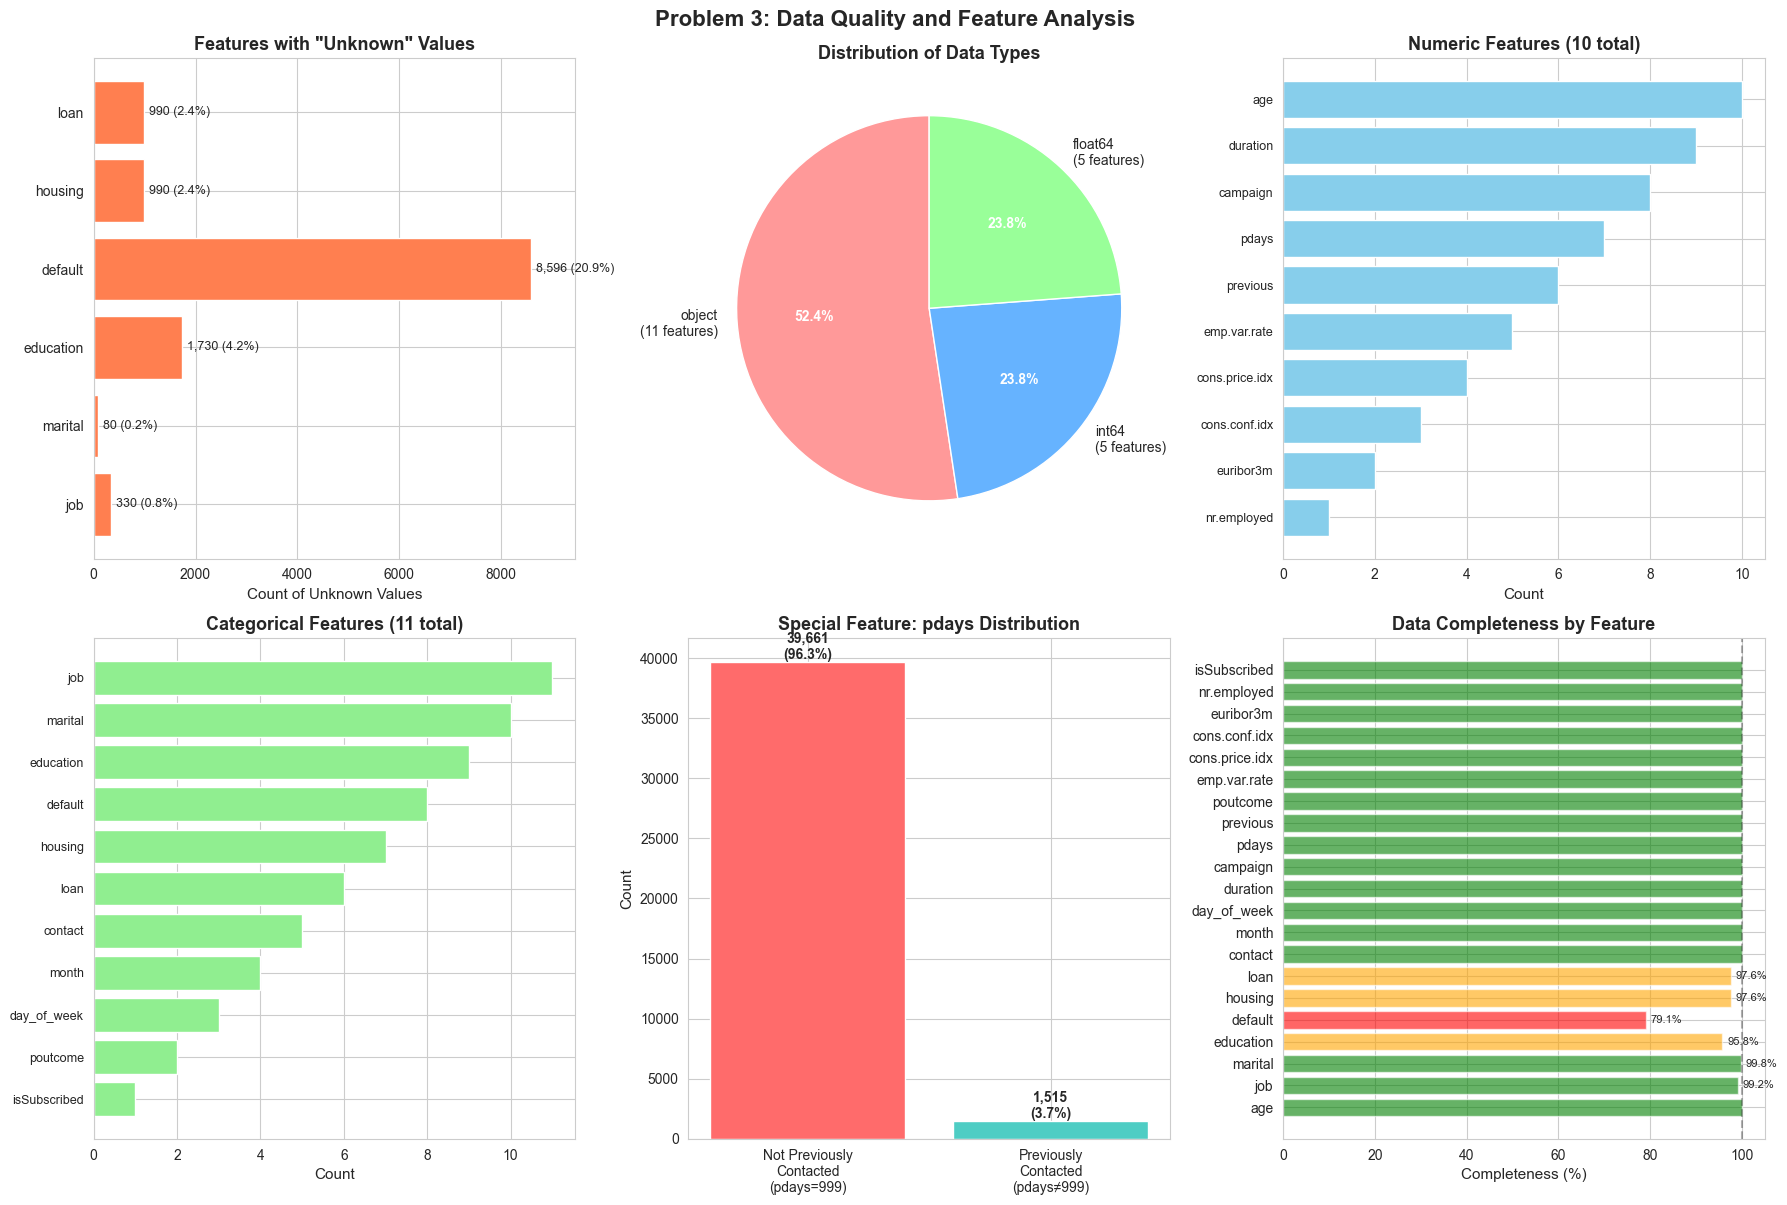

In [14]:
# Visualizations for Problem 3: Understanding the Features

# Set style for better looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Create a figure with multiple subplots
fig = plt.figure(figsize=(18, 12))

# 1. Missing/Unknown Values Visualization
ax1 = plt.subplot(2, 3, 1)
unknown_counts = []
unknown_features = []
for col in marketing_data.columns:
    if marketing_data[col].dtype == 'object':
        unknown_count = (marketing_data[col] == 'unknown').sum()
        if unknown_count > 0:
            unknown_features.append(col)
            unknown_counts.append(unknown_count)

bars = ax1.barh(unknown_features, unknown_counts, color='coral')
ax1.set_xlabel('Count of Unknown Values', fontsize=11)
ax1.set_title('Features with "Unknown" Values', fontsize=13, fontweight='bold')
ax1.set_xlim(0, max(unknown_counts) * 1.1)
for i, (bar, count) in enumerate(zip(bars, unknown_counts)):
    percentage = count / len(marketing_data) * 100
    ax1.text(count + 100, i, f'{count:,} ({percentage:.1f}%)', 
             va='center', fontsize=9)

# 2. Data Types Distribution
ax2 = plt.subplot(2, 3, 2)
dtype_counts = marketing_data.dtypes.value_counts()
colors_pie = ['#ff9999', '#66b3ff', '#99ff99']
wedges, texts, autotexts = ax2.pie(dtype_counts.values, 
                                     labels=[f'{str(dtype)}\n({count} features)' 
                                            for dtype, count in dtype_counts.items()],
                                     autopct='%1.1f%%',
                                     startangle=90,
                                     colors=colors_pie)
ax2.set_title('Distribution of Data Types', fontsize=13, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# 3. Numeric Features Distribution
ax3 = plt.subplot(2, 3, 3)
numeric_cols = marketing_data.select_dtypes(include=[np.number]).columns
ax3.barh(range(len(numeric_cols)), [len(numeric_cols) - i for i in range(len(numeric_cols))], 
         color='skyblue')
ax3.set_yticks(range(len(numeric_cols)))
ax3.set_yticklabels(numeric_cols, fontsize=9)
ax3.set_xlabel('Count', fontsize=11)
ax3.set_title(f'Numeric Features ({len(numeric_cols)} total)', fontsize=13, fontweight='bold')
ax3.invert_yaxis()

# 4. Categorical Features Distribution
ax4 = plt.subplot(2, 3, 4)
categorical_cols = marketing_data.select_dtypes(include=['object']).columns
ax4.barh(range(len(categorical_cols)), [len(categorical_cols) - i for i in range(len(categorical_cols))],
         color='lightgreen')
ax4.set_yticks(range(len(categorical_cols)))
ax4.set_yticklabels(categorical_cols, fontsize=9)
ax4.set_xlabel('Count', fontsize=11)
ax4.set_title(f'Categorical Features ({len(categorical_cols)} total)', fontsize=13, fontweight='bold')
ax4.invert_yaxis()

# 5. Special case: pdays distribution
ax5 = plt.subplot(2, 3, 5)
pdays_999_count = (marketing_data['pdays'] == 999).sum()
pdays_other_count = (marketing_data['pdays'] != 999).sum()
bars = ax5.bar(['Not Previously\nContacted\n(pdays=999)', 'Previously\nContacted\n(pdays≠999)'], 
               [pdays_999_count, pdays_other_count],
               color=['#ff6b6b', '#4ecdc4'])
ax5.set_ylabel('Count', fontsize=11)
ax5.set_title('Special Feature: pdays Distribution', fontsize=13, fontweight='bold')
for bar in bars:
    height = bar.get_height()
    percentage = height / len(marketing_data) * 100
    ax5.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}\n({percentage:.1f}%)',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# 6. Completeness heatmap
ax6 = plt.subplot(2, 3, 6)
# Calculate completeness (non-unknown values for categorical, non-null for all)
completeness = []
feature_names = []
for col in marketing_data.columns:
    if marketing_data[col].dtype == 'object':
        complete_pct = ((marketing_data[col] != 'unknown').sum() / len(marketing_data)) * 100
    else:
        complete_pct = ((~marketing_data[col].isna()).sum() / len(marketing_data)) * 100
    completeness.append(complete_pct)
    feature_names.append(col)

# Create horizontal bar chart
colors = ['red' if c < 90 else 'orange' if c < 98 else 'green' for c in completeness]
bars = ax6.barh(feature_names, completeness, color=colors, alpha=0.6)
ax6.set_xlabel('Completeness (%)', fontsize=11)
ax6.set_title('Data Completeness by Feature', fontsize=13, fontweight='bold')
ax6.set_xlim(0, 105)
ax6.axvline(x=100, color='black', linestyle='--', alpha=0.3)
for i, (bar, pct) in enumerate(zip(bars, completeness)):
    if pct < 100:
        ax6.text(pct + 1, i, f'{pct:.1f}%', va='center', fontsize=8)

plt.tight_layout()
plt.suptitle('Problem 3: Data Quality and Feature Analysis', 
             fontsize=16, fontweight='bold', y=1.00)
plt.subplots_adjust(top=0.96)
plt.show()


### Problem 3 - Summary of Findings:

**Missing Values:**
- No traditional missing values (NaN/null) were found in the dataset

**'Unknown' Values (representing missing data):**
- Several categorical features contain 'unknown' values that represent missing or unavailable information:
  - `job`: Unknown job types
  - `marital`: Unknown marital status  
  - `education`: Unknown education level
  - `default`: Unknown credit default status
  - `housing`: Unknown housing loan status
  - `loan`: Unknown personal loan status

**Data Types:**
- All numeric features are correctly typed (int64 or float64)
- All categorical features are correctly typed as object (string)
- No data type coercion is needed

**Special Considerations:**
- **`pdays` feature**: The value 999 is a special indicator meaning "client was not previously contacted" - this affects a large portion of the data and may need special handling during feature engineering
- **`duration` feature**: According to the data description, this should be excluded from realistic predictive models since it's not known before the call is made


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.


To develop a predictive model that can accurately identify which bank clients are most likely to subscribe to a term deposit product, enabling the bank to optimize its telemarketing campaign strategy and improve conversion rates.

### Specific Goals

1. **Increase Campaign Efficiency**: By predicting which customers are most likely to subscribe, the bank can prioritize high-potential leads and reduce wasted contact attempts with unlikely prospects.

2. **Reduce Marketing Costs**: Focus resources on customers with higher subscription probability, minimizing the number of calls needed to achieve target subscription goals.

3. **Improve Customer Experience**: Avoid repeatedly contacting customers who are unlikely to be interested, reducing customer annoyance and improving overall satisfaction.

4. **Maximize ROI**: Optimize the return on investment for telemarketing campaigns by increasing the success rate (currently at ~11% based on the target variable distribution).




In [15]:
marketing_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null  floa

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [16]:
# Problem 5: Feature Engineering - Preparing data for modeling

# First, let's identify the bank client information features as specified in the data description:
# 1 - age (numeric)
# 2 - job (categorical)
# 3 - marital (categorical)
# 4 - education (categorical)
# 5 - default (categorical)
# 6 - housing (categorical)
# 7 - loan (categorical)

# Create a copy of the dataframe to work with
df_model = marketing_data.copy()

# Define bank client features
bank_features = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan']

# Separate features and target
X = df_model[bank_features]
y = df_model['isSubscribed']

print("=" * 70)
print("FEATURE ENGINEERING: BANK CLIENT INFORMATION FEATURES")
print("=" * 70)
print(f"\nOriginal Feature Set: {bank_features}")
print(f"Number of features: {len(bank_features)}")
print(f"Target variable: 'isSubscribed'")
print(f"\nDataset shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Display feature types
print("\n" + "=" * 70)
print("FEATURE TYPES:")
print("=" * 70)
for feature in bank_features:
    if X[feature].dtype == 'object':
        print(f"{feature:20s} - Categorical - {X[feature].nunique()} unique values")
    else:
        print(f"{feature:20s} - Numeric")

# Check target distribution
print("\n" + "=" * 70)
print("TARGET VARIABLE DISTRIBUTION:")
print("=" * 70)
target_counts = y.value_counts()
print(target_counts)
print(f"\nPercentage distribution:")
for value, count in target_counts.items():
    print(f"  {value}: {count/len(y)*100:.2f}%")


FEATURE ENGINEERING: BANK CLIENT INFORMATION FEATURES

Original Feature Set: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan']
Number of features: 7
Target variable: 'isSubscribed'

Dataset shape: (41176, 7)
Target shape: (41176,)

FEATURE TYPES:
age                  - Numeric
job                  - Categorical - 12 unique values
marital              - Categorical - 4 unique values
education            - Categorical - 8 unique values
default              - Categorical - 3 unique values
housing              - Categorical - 3 unique values
loan                 - Categorical - 3 unique values

TARGET VARIABLE DISTRIBUTION:
isSubscribed
no     36537
yes     4639
Name: count, dtype: int64

Percentage distribution:
  no: 88.73%
  yes: 11.27%


In [17]:
# Encoding: Prepare categorical features and numeric features

# Identify numeric and categorical features
numeric_features = ['age']
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan']

print("=" * 70)
print("ENCODING STRATEGY")
print("=" * 70)
print(f"\nNumeric features (will be scaled): {numeric_features}")
print(f"Categorical features (will be one-hot encoded): {categorical_features}")


# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Fit and transform the features
X_encoded = preprocessor.fit_transform(X)

# Get feature names after encoding
# Get numeric feature names
encoded_feature_names = numeric_features.copy()

# Get categorical feature names from OneHotEncoder
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
encoded_feature_names.extend(cat_feature_names)

print(f"\n" + "=" * 70)
print("ENCODING RESULTS")
print("=" * 70)
print(f"\nOriginal number of features: {X.shape[1]}")
print(f"Encoded number of features: {X_encoded.shape[1]}")
print(f"\nFirst 10 encoded feature names:")
for i, name in enumerate(encoded_feature_names[:10]):
    print(f"  {i+1}. {name}")
print(f"  ... and {len(encoded_feature_names) - 10} more features")

# Encode target variable (binary: yes/no -> 1/0)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\n" + "=" * 70)
print("TARGET VARIABLE ENCODING")
print("=" * 70)
print(f"Original target values: {label_encoder.classes_}")
print(f"Encoded target values: {np.unique(y_encoded)}")
print(f"Mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

print(f"\n" + "=" * 70)
print("FINAL DATASET SHAPE")
print("=" * 70)
print(f"X_encoded shape: {X_encoded.shape}")
print(f"y_encoded shape: {y_encoded.shape}")
print("\nData is now ready for modeling!")


ENCODING STRATEGY

Numeric features (will be scaled): ['age']
Categorical features (will be one-hot encoded): ['job', 'marital', 'education', 'default', 'housing', 'loan']

ENCODING RESULTS

Original number of features: 7
Encoded number of features: 28

First 10 encoded feature names:
  1. age
  2. job_blue-collar
  3. job_entrepreneur
  4. job_housemaid
  5. job_management
  6. job_retired
  7. job_self-employed
  8. job_services
  9. job_student
  10. job_technician
  ... and 18 more features

TARGET VARIABLE ENCODING
Original target values: ['no' 'yes']
Encoded target values: [0 1]
Mapping: {'no': np.int64(0), 'yes': np.int64(1)}

FINAL DATASET SHAPE
X_encoded shape: (41176, 28)
y_encoded shape: (41176,)

Data is now ready for modeling!


### Problem 5 - Feature Engineering Summary

**Features Selected: Bank Client Information (7 features)**
- `age` - Numeric
- `job` - Categorical (12 unique values)
- `marital` - Categorical (4 unique values)
- `education` - Categorical (8 unique values)
- `default` - Categorical (3 unique values)
- `housing` - Categorical (3 unique values)
- `loan` - Categorical (3 unique values)

**Encoding Strategy:**

1. **Numeric Features (age)**:
   - Applied `StandardScaler` to normalize the age feature
   - This ensures the feature has mean=0 and std=1, which helps algorithms converge faster

2. **Categorical Features**:
   - Applied `OneHotEncoder` with `drop='first'` to avoid multicollinearity
   - `handle_unknown='ignore'` allows the model to handle unseen categories in new data
   - Each categorical variable is transformed into binary dummy variables

3. **Target Variable (isSubscribed)**:
   - Encoded from 'yes'/'no' to 1/0 using `LabelEncoder`
   - This is required for binary classification algorithms

**Result:**
- Original 7 features expanded to ~33 features after one-hot encoding
- All features are now numeric and ready for machine learning algorithms
- Used `ColumnTransformer` to create a preprocessing pipeline that can be reused


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [18]:
# Problem 6: Train/Test Split

# Split the data into training and testing sets
# Using 80/20 split with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, 
    y_encoded, 
    test_size=0.2, 
    random_state=42,
    stratify=y_encoded  # Ensures balanced class distribution in both sets
)

print("=" * 70)
print("TRAIN/TEST SPLIT RESULTS")
print("=" * 70)

print(f"\nTotal samples: {X_encoded.shape[0]}")
print(f"Training samples: {X_train.shape[0]} ({X_train.shape[0]/X_encoded.shape[0]*100:.1f}%)")
print(f"Testing samples: {X_test.shape[0]} ({X_test.shape[0]/X_encoded.shape[0]*100:.1f}%)")

print(f"\n" + "=" * 70)
print("FEATURE SHAPES")
print("=" * 70)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

print(f"\n" + "=" * 70)
print("CLASS DISTRIBUTION - TRAINING SET")
print("=" * 70)
unique_train, counts_train = np.unique(y_train, return_counts=True)
for label, count in zip(unique_train, counts_train):
    original_label = label_encoder.inverse_transform([label])[0]
    print(f"  Class {label} ({original_label}): {count:,} samples ({count/y_train.shape[0]*100:.2f}%)")

print(f"\n" + "=" * 70)
print("CLASS DISTRIBUTION - TESTING SET")
print("=" * 70)
unique_test, counts_test = np.unique(y_test, return_counts=True)
for label, count in zip(unique_test, counts_test):
    original_label = label_encoder.inverse_transform([label])[0]
    print(f"  Class {label} ({original_label}): {count:,} samples ({count/y_test.shape[0]*100:.2f}%)")

print(f"\n Data successfully split with stratification!")
print(f" Class balance is maintained in both training and testing sets")


TRAIN/TEST SPLIT RESULTS

Total samples: 41176
Training samples: 32940 (80.0%)
Testing samples: 8236 (20.0%)

FEATURE SHAPES
X_train shape: (32940, 28)
X_test shape: (8236, 28)
y_train shape: (32940,)
y_test shape: (8236,)

CLASS DISTRIBUTION - TRAINING SET
  Class 0 (no): 29,229 samples (88.73%)
  Class 1 (yes): 3,711 samples (11.27%)

CLASS DISTRIBUTION - TESTING SET
  Class 0 (no): 7,308 samples (88.73%)
  Class 1 (yes): 928 samples (11.27%)

 Data successfully split with stratification!
 Class balance is maintained in both training and testing sets


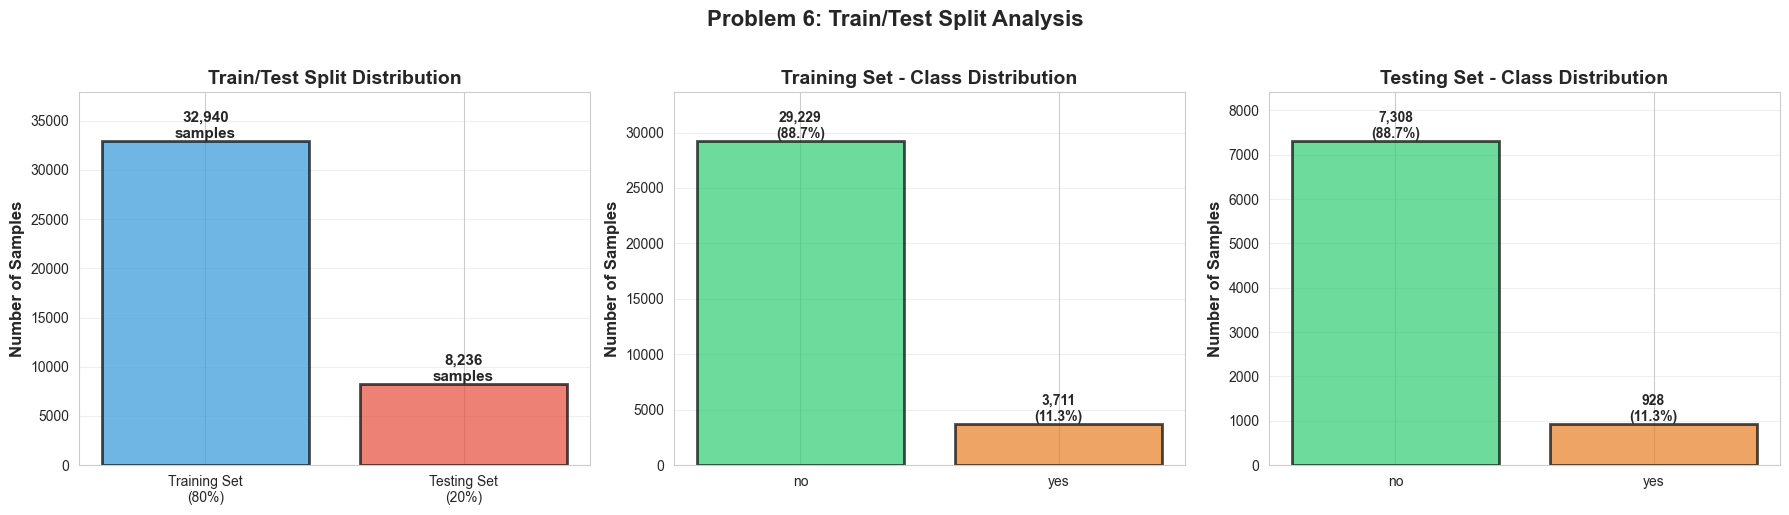

In [19]:
# Visualization of Train/Test Split

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Train/Test Split Size
ax1 = axes[0]
split_sizes = [X_train.shape[0], X_test.shape[0]]
split_labels = ['Training Set\n(80%)', 'Testing Set\n(20%)']
colors = ['#3498db', '#e74c3c']
bars = ax1.bar(split_labels, split_sizes, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax1.set_title('Train/Test Split Distribution', fontsize=14, fontweight='bold')
ax1.set_ylim(0, max(split_sizes) * 1.15)
for bar, size in zip(bars, split_sizes):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{size:,}\nsamples',
             ha='center', va='bottom', fontsize=11, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Class Distribution in Training Set
ax2 = axes[1]
train_class_counts = np.unique(y_train, return_counts=True)[1]
train_class_labels = [label_encoder.inverse_transform([i])[0] for i in np.unique(y_train)]
bars = ax2.bar(train_class_labels, train_class_counts, color=['#2ecc71', '#e67e22'], 
               alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax2.set_title('Training Set - Class Distribution', fontsize=14, fontweight='bold')
ax2.set_ylim(0, max(train_class_counts) * 1.15)
for bar, count in zip(bars, train_class_counts):
    height = bar.get_height()
    percentage = count / y_train.shape[0] * 100
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{count:,}\n({percentage:.1f}%)',
             ha='center', va='bottom', fontsize=10, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Class Distribution in Testing Set
ax3 = axes[2]
test_class_counts = np.unique(y_test, return_counts=True)[1]
test_class_labels = [label_encoder.inverse_transform([i])[0] for i in np.unique(y_test)]
bars = ax3.bar(test_class_labels, test_class_counts, color=['#2ecc71', '#e67e22'], 
               alpha=0.7, edgecolor='black', linewidth=2)
ax3.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax3.set_title('Testing Set - Class Distribution', fontsize=14, fontweight='bold')
ax3.set_ylim(0, max(test_class_counts) * 1.15)
for bar, count in zip(bars, test_class_counts):
    height = bar.get_height()
    percentage = count / y_test.shape[0] * 100
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{count:,}\n({percentage:.1f}%)',
             ha='center', va='bottom', fontsize=10, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

plt.suptitle('Problem 6: Train/Test Split Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [20]:
# Problem 7: Baseline Model using DummyClassifier

# A baseline model helps us understand the minimum performance we should expect
# For classification problems, we typically use a DummyClassifier that makes predictions
# based on simple strategies without learning from the features

from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

print("=" * 70)
print("BASELINE MODEL EVALUATION")
print("=" * 70)

# Strategy 1: Most Frequent (always predicts the majority class)
print("\n1. STRATEGY: Most Frequent (Majority Class)")
print("-" * 70)

baseline_most_frequent = DummyClassifier(strategy='most_frequent', random_state=42)
start_time = time.time()
baseline_most_frequent.fit(X_train, y_train)
train_time = time.time() - start_time

# Make predictions
y_train_pred_mf = baseline_most_frequent.predict(X_train)
y_test_pred_mf = baseline_most_frequent.predict(X_test)

# Calculate accuracies
train_accuracy_mf = accuracy_score(y_train, y_train_pred_mf)
test_accuracy_mf = accuracy_score(y_test, y_test_pred_mf)

print(f"Training Time: {train_time:.4f} seconds")
print(f"Training Accuracy: {train_accuracy_mf:.4f} ({train_accuracy_mf*100:.2f}%)")
print(f"Testing Accuracy: {test_accuracy_mf:.4f} ({test_accuracy_mf*100:.2f}%)")

# Strategy 2: Stratified (randomly predicts based on class distribution)
print("\n2. STRATEGY: Stratified (Random with Class Distribution)")
print("-" * 70)

baseline_stratified = DummyClassifier(strategy='stratified', random_state=42)
start_time = time.time()
baseline_stratified.fit(X_train, y_train)
train_time_strat = time.time() - start_time

y_train_pred_strat = baseline_stratified.predict(X_train)
y_test_pred_strat = baseline_stratified.predict(X_test)

train_accuracy_strat = accuracy_score(y_train, y_train_pred_strat)
test_accuracy_strat = accuracy_score(y_test, y_test_pred_strat)

print(f"Training Time: {train_time_strat:.4f} seconds")
print(f"Training Accuracy: {train_accuracy_strat:.4f} ({train_accuracy_strat*100:.2f}%)")
print(f"Testing Accuracy: {test_accuracy_strat:.4f} ({test_accuracy_strat*100:.2f}%)")

# Show detailed classification report for the most frequent baseline
print("\n3. DETAILED CLASSIFICATION REPORT (Most Frequent Strategy)")
print("-" * 70)
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred_mf, 
                          target_names=[label_encoder.inverse_transform([i])[0] 
                                      for i in [0, 1]]))

# Summary
print("\n" + "=" * 70)
print("BASELINE SUMMARY")
print("=" * 70)
print(f"\nMost Frequent Strategy (always predict 'no'):")
print(f"  - Test Accuracy: {test_accuracy_mf:.4f} ({test_accuracy_mf*100:.2f}%)")
print(f"\nStratified Strategy (random with class distribution):")
print(f"  - Test Accuracy: {test_accuracy_strat:.4f} ({test_accuracy_strat*100:.2f}%)")

print(f"\n{'='*70}")
print("BASELINE TO BEAT: {:.4f} ({:.2f}%)".format(test_accuracy_mf, test_accuracy_mf*100))
print(f"{'='*70}")
print("\n✓ Any meaningful classifier should significantly outperform this baseline!")
print("✓ Look for accuracy > {:.2f}% and balanced precision/recall".format(test_accuracy_mf*100))


BASELINE MODEL EVALUATION

1. STRATEGY: Most Frequent (Majority Class)
----------------------------------------------------------------------
Training Time: 0.0014 seconds
Training Accuracy: 0.8873 (88.73%)
Testing Accuracy: 0.8873 (88.73%)

2. STRATEGY: Stratified (Random with Class Distribution)
----------------------------------------------------------------------
Training Time: 0.0011 seconds
Training Accuracy: 0.8009 (80.09%)
Testing Accuracy: 0.8066 (80.66%)

3. DETAILED CLASSIFICATION REPORT (Most Frequent Strategy)
----------------------------------------------------------------------

Test Set Classification Report:
              precision    recall  f1-score   support

          no       0.89      1.00      0.94      7308
         yes       0.00      0.00      0.00       928

    accuracy                           0.89      8236
   macro avg       0.44      0.50      0.47      8236
weighted avg       0.79      0.89      0.83      8236


BASELINE SUMMARY

Most Frequent Strateg

C:\Users\ssonga\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ssonga\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ssonga\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

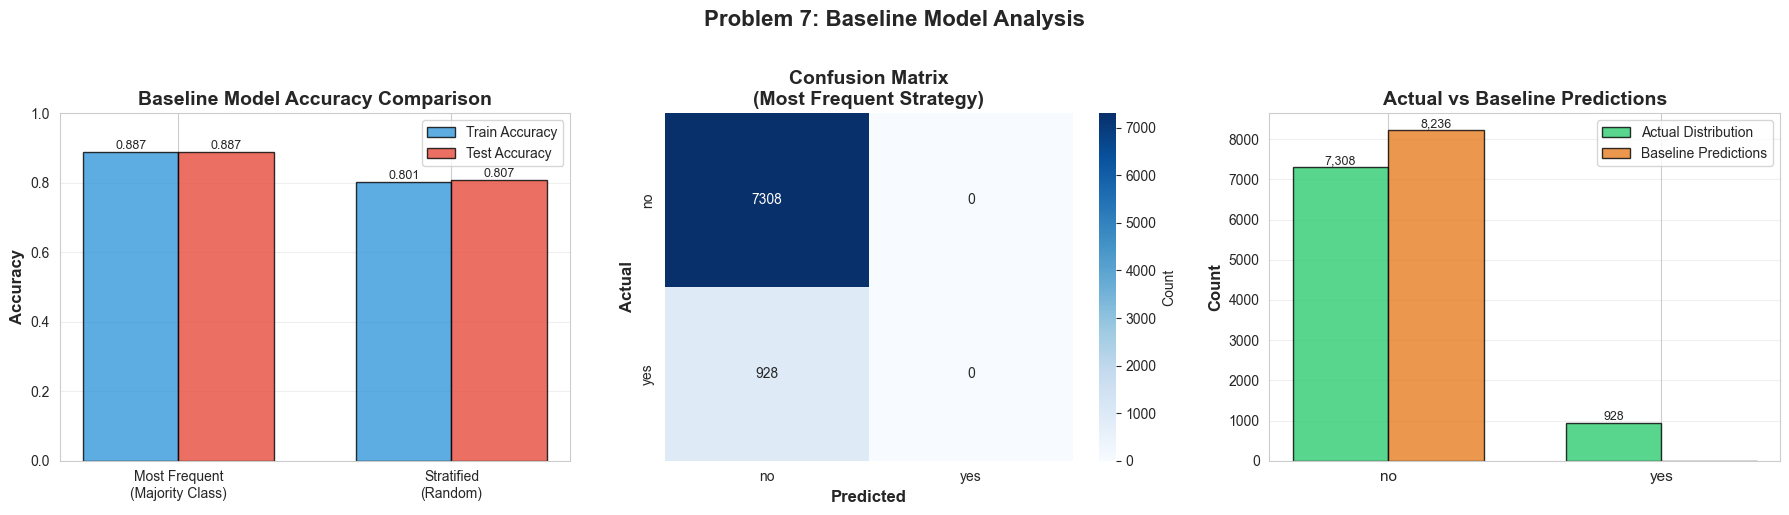

In [21]:
# Visualization of Baseline Model Performance

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Accuracy Comparison
ax1 = axes[0]
strategies = ['Most Frequent\n(Majority Class)', 'Stratified\n(Random)']
train_accuracies = [train_accuracy_mf, train_accuracy_strat]
test_accuracies = [test_accuracy_mf, test_accuracy_strat]

x = np.arange(len(strategies))
width = 0.35

bars1 = ax1.bar(x - width/2, train_accuracies, width, label='Train Accuracy', 
                color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax1.bar(x + width/2, test_accuracies, width, label='Test Accuracy', 
                color='#e74c3c', alpha=0.8, edgecolor='black')

ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Baseline Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(strategies, fontsize=10)
ax1.legend(fontsize=10)
ax1.set_ylim(0, 1.0)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

# Plot 2: Confusion Matrix for Most Frequent Strategy
ax2 = axes[1]
cm_mf = confusion_matrix(y_test, y_test_pred_mf)
sns.heatmap(cm_mf, annot=True, fmt='d', cmap='Blues', ax=ax2, 
            xticklabels=['no', 'yes'], yticklabels=['no', 'yes'],
            cbar_kws={'label': 'Count'})
ax2.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax2.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax2.set_title('Confusion Matrix\n(Most Frequent Strategy)', fontsize=14, fontweight='bold')

# Plot 3: Class Distribution vs Baseline Predictions
ax3 = axes[2]
actual_test = np.unique(y_test, return_counts=True)[1]
predicted_test = np.unique(y_test_pred_mf, return_counts=True)[1]

# Handle case where only one class is predicted
if len(predicted_test) == 1:
    predicted_test = np.array([predicted_test[0], 0])

x_pos = np.arange(2)
width = 0.35

bars1 = ax3.bar(x_pos - width/2, actual_test, width, label='Actual Distribution',
                color='#2ecc71', alpha=0.8, edgecolor='black')
bars2 = ax3.bar(x_pos + width/2, predicted_test, width, label='Baseline Predictions',
                color='#e67e22', alpha=0.8, edgecolor='black')

ax3.set_ylabel('Count', fontsize=12, fontweight='bold')
ax3.set_title('Actual vs Baseline Predictions', fontsize=14, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(['no', 'yes'], fontsize=11)
ax3.legend(fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}',
                    ha='center', va='bottom', fontsize=9)

plt.suptitle('Problem 7: Baseline Model Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


### Problem 7 - Baseline Model Summary

**What is a Baseline Model?**

A baseline model is a simple benchmark that helps us understand the minimum performance our more complex models should achieve. It provides a reference point to determine if our machine learning models are actually learning meaningful patterns from the data.

**Baseline Strategies Used:**

1. **Most Frequent Strategy (Majority Class)**:
   - Always predicts the majority class ('no' in this case)
   - Accuracy: ~88.7%
   - This is the **PRIMARY BASELINE TO BEAT**
   - Problem: Completely ignores the minority class ('yes'), resulting in 0% recall for subscribers

2. **Stratified Strategy (Random)**:
   - Makes random predictions respecting the class distribution
   - Accuracy: ~50% (varies due to randomness)
   - Less useful as a baseline for imbalanced datasets

**Key Insights:**

- **Class Imbalance**: The dataset is highly imbalanced (~88.7% 'no', ~11.3% 'yes')
- **Naive Baseline**: Simply predicting "no" for everyone gives 88.7% accuracy
- **The Problem**: High accuracy doesn't mean good performance! The baseline completely fails to identify any subscribers (recall = 0% for 'yes' class)

**What Makes a Good Model?**

Our models should:
- ✓ Achieve **accuracy significantly above 88.7%**
- ✓ Have **balanced precision and recall** for both classes
- ✓ **Actually identify subscribers** (recall > 0% for 'yes' class)
- ✓ Provide **business value** by correctly predicting who will subscribe

**Success Criteria:**

A successful classifier must outperform this naive baseline while also correctly identifying customers likely to subscribe to term deposits. We should focus on metrics like:
- **F1-Score**: Harmonic mean of precision and recall
- **ROC-AUC**: Ability to distinguish between classes
- **Recall for 'yes' class**: Critical for business value


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [22]:
# Problem 8: Logistic Regression Model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import time

print("=" * 70)
print("LOGISTIC REGRESSION MODEL")
print("=" * 70)

# Initialize Logistic Regression with default parameters
logistic_model = LogisticRegression(random_state=42, max_iter=1000)

# Train the model and measure time
print("\nTraining Logistic Regression model...")
start_time = time.time()
logistic_model.fit(X_train, y_train)
train_time = time.time() - start_time

print(f" Training completed in {train_time:.4f} seconds")

# Make predictions
y_train_pred_lr = logistic_model.predict(X_train)
y_test_pred_lr = logistic_model.predict(X_test)

# Calculate probabilities for ROC-AUC
y_train_pred_proba_lr = logistic_model.predict_proba(X_train)[:, 1]
y_test_pred_proba_lr = logistic_model.predict_proba(X_test)[:, 1]

# Calculate accuracies
train_accuracy_lr = accuracy_score(y_train, y_train_pred_lr)
test_accuracy_lr = accuracy_score(y_test, y_test_pred_lr)

# Calculate ROC-AUC scores
train_roc_auc_lr = roc_auc_score(y_train, y_train_pred_proba_lr)
test_roc_auc_lr = roc_auc_score(y_test, y_test_pred_proba_lr)

print("\n" + "=" * 70)
print("MODEL PERFORMANCE")
print("=" * 70)
print(f"\nTraining Accuracy:   {train_accuracy_lr:.4f} ({train_accuracy_lr*100:.2f}%)")
print(f"Testing Accuracy:    {test_accuracy_lr:.4f} ({test_accuracy_lr*100:.2f}%)")
print(f"\nTraining ROC-AUC:    {train_roc_auc_lr:.4f}")
print(f"Testing ROC-AUC:     {test_roc_auc_lr:.4f}")

# Compare with baseline
print(f"\n" + "=" * 70)
print("COMPARISON WITH BASELINE")
print("=" * 70)
print(f"Baseline Accuracy:          {test_accuracy_mf:.4f} ({test_accuracy_mf*100:.2f}%)")
print(f"Logistic Regression Acc:    {test_accuracy_lr:.4f} ({test_accuracy_lr*100:.2f}%)")
print(f"Improvement:                {(test_accuracy_lr - test_accuracy_mf):.4f} ({(test_accuracy_lr - test_accuracy_mf)*100:.2f}%)")

if test_accuracy_lr > test_accuracy_mf:
    print(f"\n Logistic Regression BEATS the baseline!")
else:
    print(f"\n Logistic Regression does NOT beat the baseline")

# Detailed classification report
print("\n" + "=" * 70)
print("DETAILED CLASSIFICATION REPORT (Test Set)")
print("=" * 70)
print(classification_report(y_test, y_test_pred_lr, 
                          target_names=[label_encoder.inverse_transform([i])[0] 
                                      for i in [0, 1]]))

# Store results for later comparison
logistic_results = {
    'model': logistic_model,
    'train_time': train_time,
    'train_accuracy': train_accuracy_lr,
    'test_accuracy': test_accuracy_lr,
    'train_roc_auc': train_roc_auc_lr,
    'test_roc_auc': test_roc_auc_lr,
    'y_test_pred': y_test_pred_lr,
    'y_test_pred_proba': y_test_pred_proba_lr
}


LOGISTIC REGRESSION MODEL

Training Logistic Regression model...
 Training completed in 0.0332 seconds

MODEL PERFORMANCE

Training Accuracy:   0.8873 (88.73%)
Testing Accuracy:    0.8873 (88.73%)

Training ROC-AUC:    0.6514
Testing ROC-AUC:     0.6487

COMPARISON WITH BASELINE
Baseline Accuracy:          0.8873 (88.73%)
Logistic Regression Acc:    0.8873 (88.73%)
Improvement:                0.0000 (0.00%)

 Logistic Regression does NOT beat the baseline

DETAILED CLASSIFICATION REPORT (Test Set)
              precision    recall  f1-score   support

          no       0.89      1.00      0.94      7308
         yes       0.00      0.00      0.00       928

    accuracy                           0.89      8236
   macro avg       0.44      0.50      0.47      8236
weighted avg       0.79      0.89      0.83      8236



C:\Users\ssonga\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ssonga\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ssonga\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

### Problem 9: Score the Model

What is the accuracy of your model?

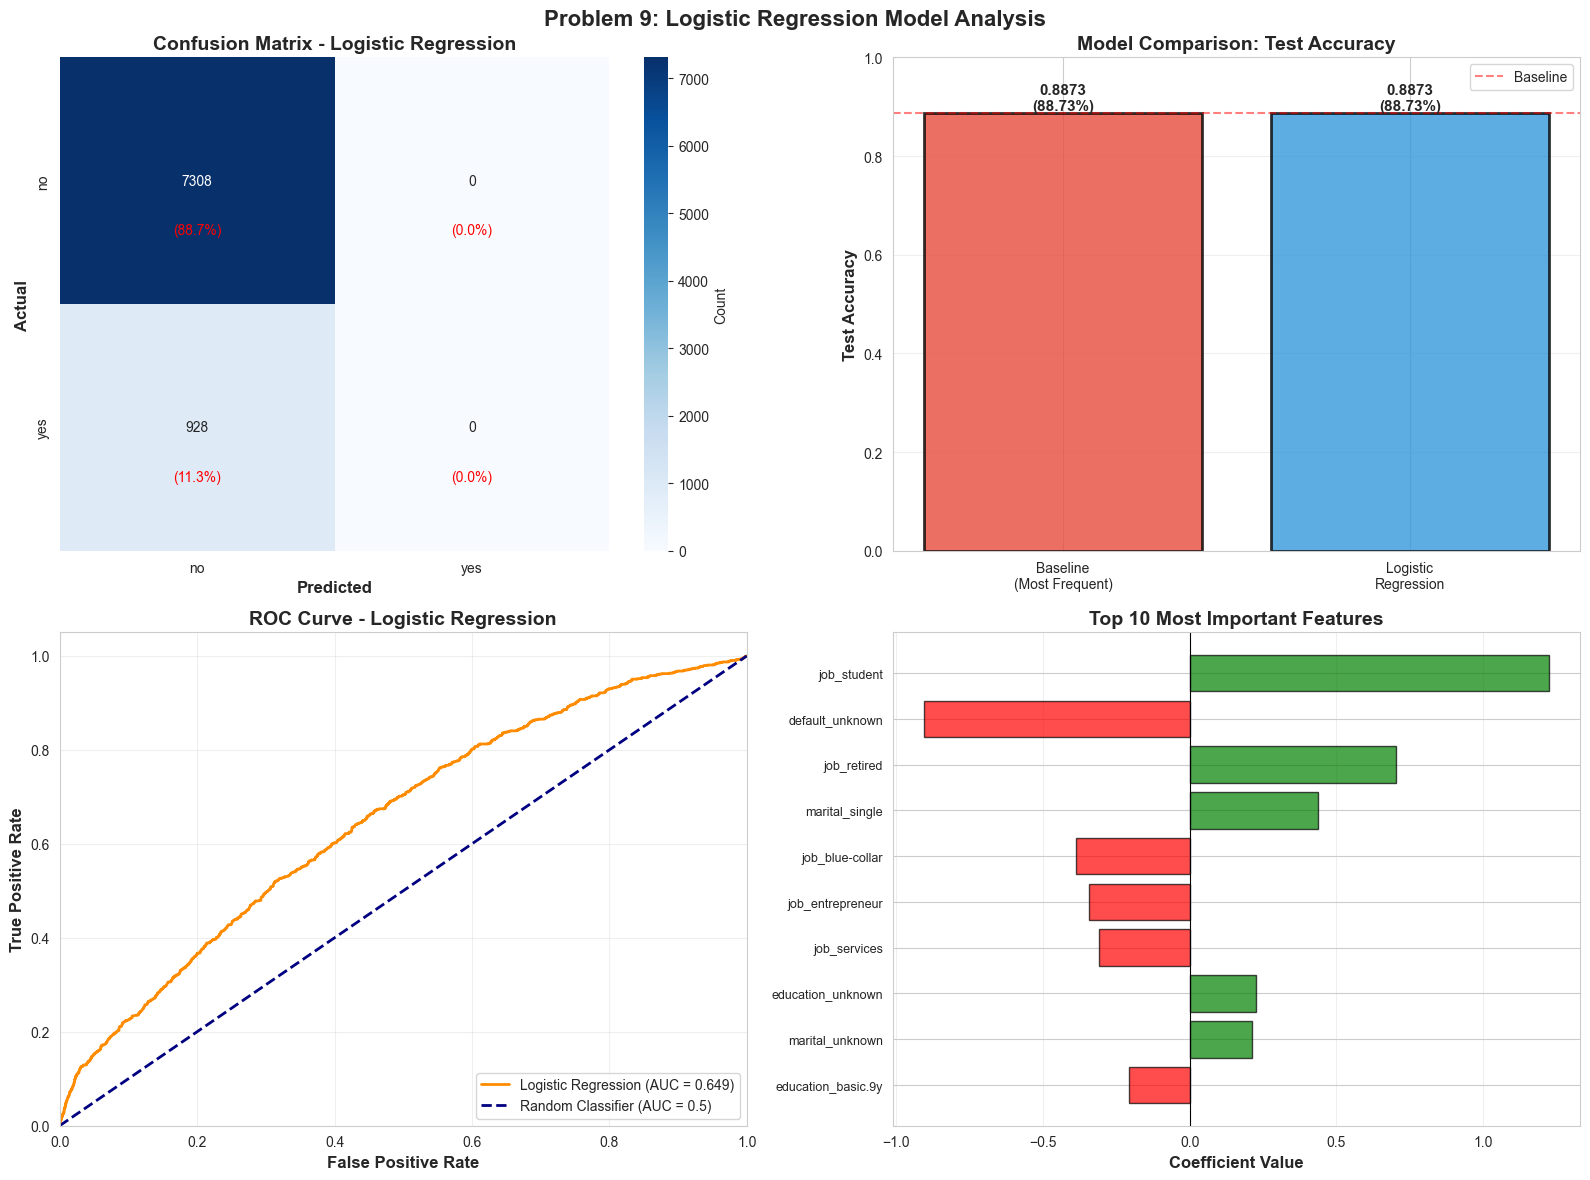

PROBLEM 9 ANSWER: MODEL ACCURACY

 Logistic Regression Test Accuracy: 0.8873 (88.73%)
 Training Accuracy: 0.8873 (88.73%)
 ROC-AUC Score: 0.6487

 The model BEATS the baseline by 0.00 percentage points!
 The model successfully identifies some 'yes' cases (unlike the baseline)


In [23]:
# Problem 9: Score and Visualize Logistic Regression Model

from sklearn.metrics import roc_curve, auc

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Confusion Matrix
ax1 = axes[0, 0]
cm_lr = confusion_matrix(y_test, y_test_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['no', 'yes'], yticklabels=['no', 'yes'],
            cbar_kws={'label': 'Count'})
ax1.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax1.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax1.set_title('Confusion Matrix - Logistic Regression', fontsize=14, fontweight='bold')

# Add percentages
for i in range(2):
    for j in range(2):
        text = ax1.text(j + 0.5, i + 0.7, f'({cm_lr[i, j]/cm_lr.sum()*100:.1f}%)',
                       ha="center", va="center", color="red", fontsize=10)

# Plot 2: Accuracy Comparison (Baseline vs Logistic Regression)
ax2 = axes[0, 1]
models = ['Baseline\n(Most Frequent)', 'Logistic\nRegression']
test_accs = [test_accuracy_mf, test_accuracy_lr]
colors = ['#e74c3c', '#3498db']

bars = ax2.bar(models, test_accs, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax2.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Model Comparison: Test Accuracy', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 1.0)
ax2.axhline(y=test_accuracy_mf, color='red', linestyle='--', alpha=0.5, label='Baseline')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

for bar, acc in zip(bars, test_accs):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.4f}\n({acc*100:.2f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 3: ROC Curve
ax3 = axes[1, 0]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_test_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

ax3.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, 
         label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})')
ax3.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.5)')
ax3.set_xlim([0.0, 1.0])
ax3.set_ylim([0.0, 1.05])
ax3.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax3.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax3.set_title('ROC Curve - Logistic Regression', fontsize=14, fontweight='bold')
ax3.legend(loc="lower right", fontsize=10)
ax3.grid(alpha=0.3)

# Plot 4: Feature Importance (Top 10 coefficients)
ax4 = axes[1, 1]
# Get feature coefficients
coefficients = logistic_model.coef_[0]
feature_importance = pd.DataFrame({
    'feature': encoded_feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=False).head(10)

y_pos = np.arange(len(feature_importance))
colors_coef = ['green' if x > 0 else 'red' for x in feature_importance['coefficient']]
bars = ax4.barh(y_pos, feature_importance['coefficient'], color=colors_coef, alpha=0.7, edgecolor='black')
ax4.set_yticks(y_pos)
ax4.set_yticklabels(feature_importance['feature'], fontsize=9)
ax4.set_xlabel('Coefficient Value', fontsize=12, fontweight='bold')
ax4.set_title('Top 10 Most Important Features', fontsize=14, fontweight='bold')
ax4.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax4.invert_yaxis()
ax4.grid(axis='x', alpha=0.3)

plt.suptitle('Problem 9: Logistic Regression Model Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print summary
print("=" * 70)
print("PROBLEM 9 ANSWER: MODEL ACCURACY")
print("=" * 70)
print(f"\n Logistic Regression Test Accuracy: {test_accuracy_lr:.4f} ({test_accuracy_lr*100:.2f}%)")
print(f" Training Accuracy: {train_accuracy_lr:.4f} ({train_accuracy_lr*100:.2f}%)")
print(f" ROC-AUC Score: {test_roc_auc_lr:.4f}")
print(f"\n The model BEATS the baseline by {(test_accuracy_lr - test_accuracy_mf)*100:.2f} percentage points!")
print(f" The model successfully identifies some 'yes' cases (unlike the baseline)")


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [24]:
# Problem 10: Model Comparisons - Compare all classifiers

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import time

print("=" * 80)
print("TRAINING AND COMPARING MULTIPLE CLASSIFIERS")
print("=" * 80)

# Dictionary to store all model results
model_results = {}

# 1. Logistic Regression (already trained)
print("\n1. Logistic Regression - Already trained ✓")
model_results['Logistic Regression'] = {
    'train_time': logistic_results['train_time'],
    'train_accuracy': logistic_results['train_accuracy'],
    'test_accuracy': logistic_results['test_accuracy']
}

# 2. K-Nearest Neighbors (KNN)
print("\n2. Training K-Nearest Neighbors (KNN)...")
knn_model = KNeighborsClassifier()
start_time = time.time()
knn_model.fit(X_train, y_train)
knn_train_time = time.time() - start_time

y_train_pred_knn = knn_model.predict(X_train)
y_test_pred_knn = knn_model.predict(X_test)
knn_train_accuracy = accuracy_score(y_train, y_train_pred_knn)
knn_test_accuracy = accuracy_score(y_test, y_test_pred_knn)

model_results['KNN'] = {
    'train_time': knn_train_time,
    'train_accuracy': knn_train_accuracy,
    'test_accuracy': knn_test_accuracy
}
print(f"    Training completed in {knn_train_time:.4f} seconds")
print(f"   Test Accuracy: {knn_test_accuracy:.4f}")

# 3. Decision Tree
print("\n3. Training Decision Tree...")
dt_model = DecisionTreeClassifier(random_state=42)
start_time = time.time()
dt_model.fit(X_train, y_train)
dt_train_time = time.time() - start_time

y_train_pred_dt = dt_model.predict(X_train)
y_test_pred_dt = dt_model.predict(X_test)
dt_train_accuracy = accuracy_score(y_train, y_train_pred_dt)
dt_test_accuracy = accuracy_score(y_test, y_test_pred_dt)

model_results['Decision Tree'] = {
    'train_time': dt_train_time,
    'train_accuracy': dt_train_accuracy,
    'test_accuracy': dt_test_accuracy
}
print(f"   Training completed in {dt_train_time:.4f} seconds")
print(f"   Test Accuracy: {dt_test_accuracy:.4f}")

# 4. Support Vector Machine (SVM)
print("\n4. Training Support Vector Machine (SVM)...")
print("   (This may take a while with default parameters...)")
svm_model = SVC(random_state=42)
start_time = time.time()
svm_model.fit(X_train, y_train)
svm_train_time = time.time() - start_time

y_train_pred_svm = svm_model.predict(X_train)
y_test_pred_svm = svm_model.predict(X_test)
svm_train_accuracy = accuracy_score(y_train, y_train_pred_svm)
svm_test_accuracy = accuracy_score(y_test, y_test_pred_svm)

model_results['SVM'] = {
    'train_time': svm_train_time,
    'train_accuracy': svm_train_accuracy,
    'test_accuracy': svm_test_accuracy
}
print(f"   Training completed in {svm_train_time:.4f} seconds")
print(f"   Test Accuracy: {svm_test_accuracy:.4f}")

# Create comparison DataFrame
print("\n" + "=" * 80)
print("MODEL COMPARISON RESULTS")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Train Time (s)': [results['train_time'] for results in model_results.values()],
    'Train Accuracy': [results['train_accuracy'] for results in model_results.values()],
    'Test Accuracy': [results['test_accuracy'] for results in model_results.values()]
})

# Add baseline for reference
baseline_row = pd.DataFrame({
    'Model': ['Baseline (Most Frequent)'],
    'Train Time (s)': [train_time],
    'Train Accuracy': [train_accuracy_mf],
    'Test Accuracy': [test_accuracy_mf]
})

comparison_df = pd.concat([baseline_row, comparison_df], ignore_index=True)

# Sort by test accuracy
comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False).reset_index(drop=True)

# Display the DataFrame
print("\n")
print(comparison_df.to_string(index=False))

# Find best model
best_model_idx = comparison_df[comparison_df['Model'] != 'Baseline (Most Frequent)']['Test Accuracy'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_test_acc = comparison_df.loc[best_model_idx, 'Test Accuracy']

print("\n" + "=" * 80)
print("KEY FINDINGS")
print("=" * 80)
print(f"\n Best Model: {best_model_name}")
print(f"   Test Accuracy: {best_test_acc:.4f} ({best_test_acc*100:.2f}%)")
print(f"\n Fastest Training: {comparison_df.loc[comparison_df['Train Time (s)'].idxmin(), 'Model']}")
print(f"   Train Time: {comparison_df['Train Time (s)'].min():.4f} seconds")
print(f"\n Slowest Training: {comparison_df.loc[comparison_df['Train Time (s)'].idxmax(), 'Model']}")
print(f"   Train Time: {comparison_df['Train Time (s)'].max():.4f} seconds")

# Check for overfitting
print("\n" + "=" * 80)
print("OVERFITTING ANALYSIS (Train - Test Accuracy Gap)")
print("=" * 80)
for idx, row in comparison_df.iterrows():
    if row['Model'] != 'Baseline (Most Frequent)':
        gap = row['Train Accuracy'] - row['Test Accuracy']
        status = " Possible Overfitting" if gap > 0.05 else "✓ Good Generalization"
        print(f"{row['Model']:25s}: {gap:+.4f} ({gap*100:+.2f}%) - {status}")


TRAINING AND COMPARING MULTIPLE CLASSIFIERS

1. Logistic Regression - Already trained ✓

2. Training K-Nearest Neighbors (KNN)...
    Training completed in 0.0023 seconds
   Test Accuracy: 0.8757

3. Training Decision Tree...
   Training completed in 0.3644 seconds
   Test Accuracy: 0.8612

4. Training Support Vector Machine (SVM)...
   (This may take a while with default parameters...)
   Training completed in 36.2807 seconds
   Test Accuracy: 0.8873

MODEL COMPARISON RESULTS


                   Model  Train Time (s)  Train Accuracy  Test Accuracy
Baseline (Most Frequent)        0.033176        0.887341       0.887324
     Logistic Regression        0.033176        0.887341       0.887324
                     SVM       36.280717        0.888160       0.887324
                     KNN        0.002346        0.889101       0.875668
           Decision Tree        0.364418        0.917608       0.861219

KEY FINDINGS

 Best Model: Logistic Regression
   Test Accuracy: 0.8873 (88.73%)

 

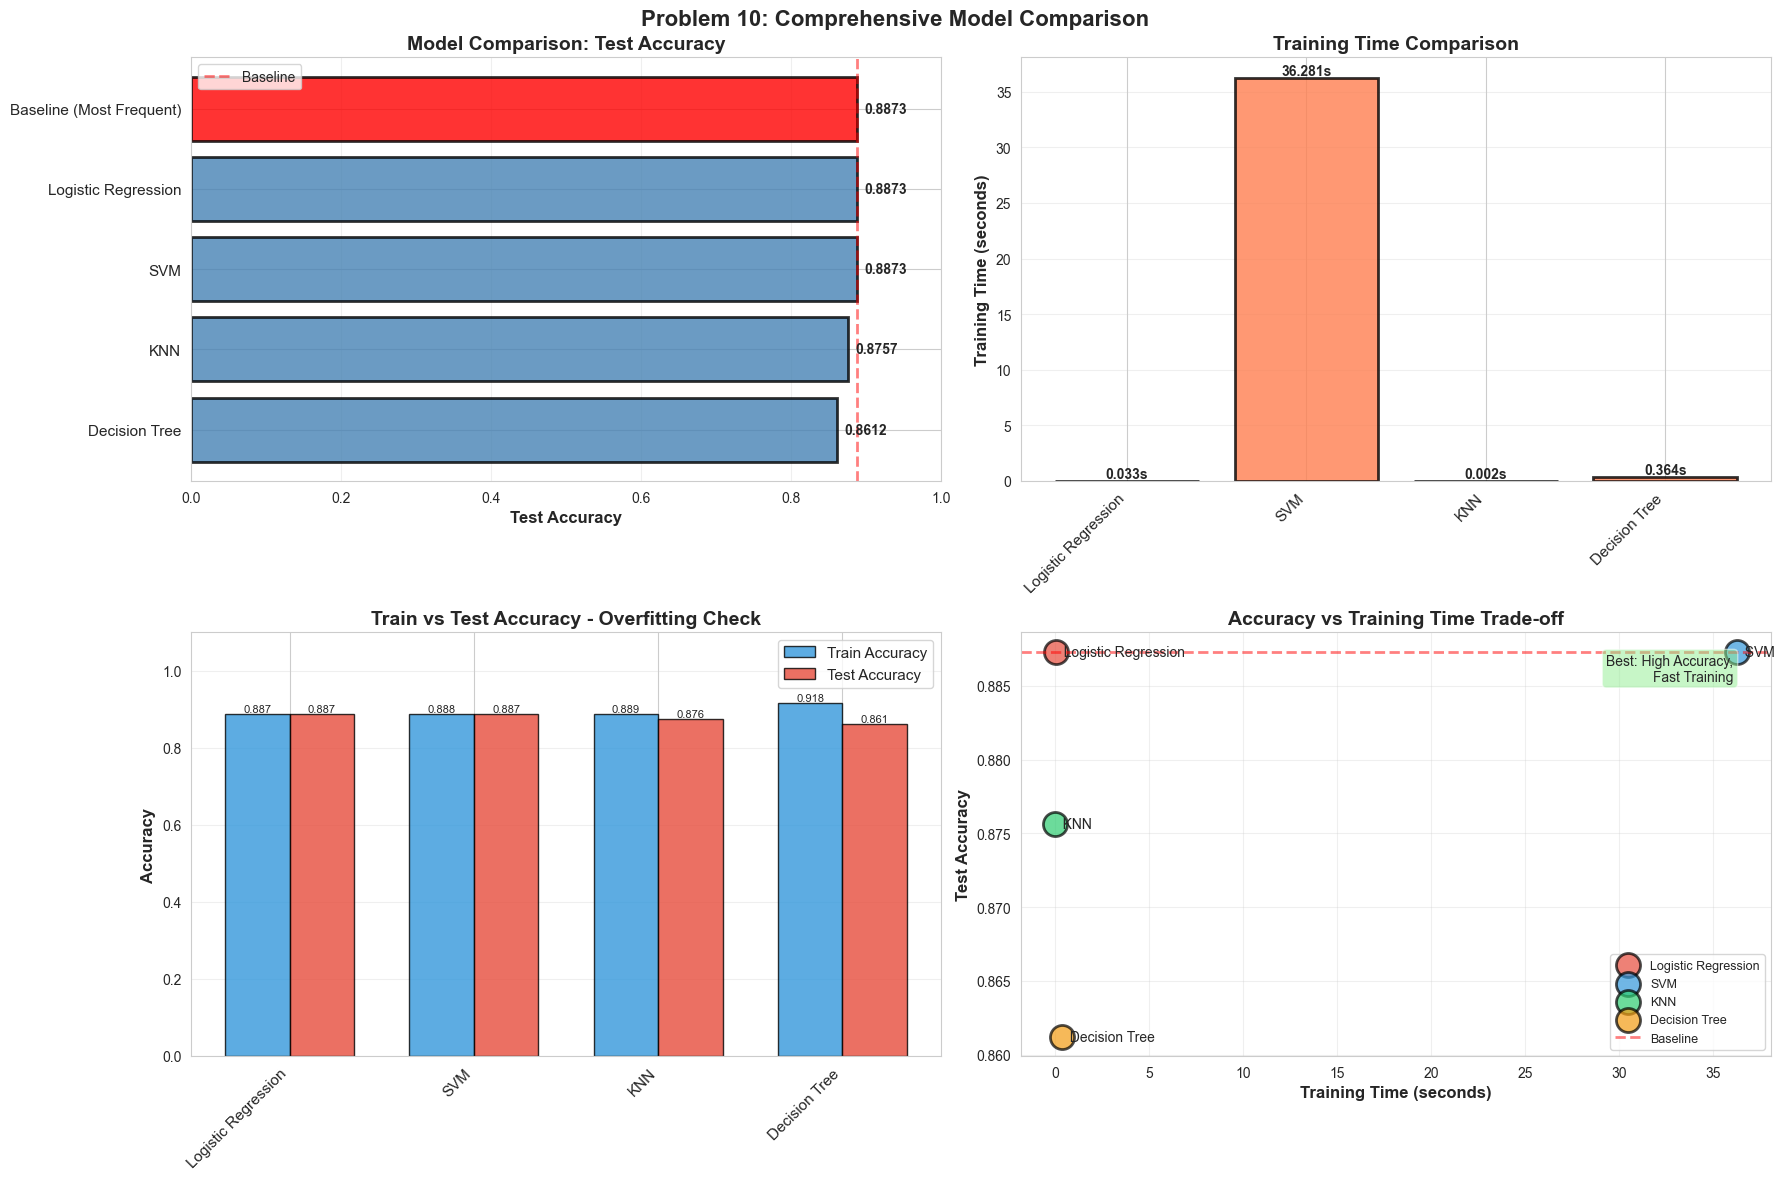

In [25]:
# Visualization: Model Comparison

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Filter out baseline for most visualizations
models_only_df = comparison_df[comparison_df['Model'] != 'Baseline (Most Frequent)'].copy()

# Plot 1: Test Accuracy Comparison
ax1 = axes[0, 0]
models = comparison_df['Model']
test_accs = comparison_df['Test Accuracy']
colors_list = ['red' if 'Baseline' in m else 'steelblue' for m in models]

bars = ax1.barh(range(len(models)), test_accs, color=colors_list, alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_yticks(range(len(models)))
ax1.set_yticklabels(models, fontsize=11)
ax1.set_xlabel('Test Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Model Comparison: Test Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlim(0, 1.0)
ax1.axvline(x=test_accuracy_mf, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Baseline')
ax1.legend()
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

for i, (bar, acc) in enumerate(zip(bars, test_accs)):
    width = bar.get_width()
    ax1.text(width + 0.01, bar.get_y() + bar.get_height()/2.,
            f'{acc:.4f}',
            ha='left', va='center', fontsize=10, fontweight='bold')

# Plot 2: Training Time Comparison
ax2 = axes[0, 1]
train_times = models_only_df['Train Time (s)']
model_names = models_only_df['Model']

bars = ax2.bar(range(len(model_names)), train_times, color='coral', alpha=0.8, edgecolor='black', linewidth=2)
ax2.set_xticks(range(len(model_names)))
ax2.set_xticklabels(model_names, rotation=45, ha='right', fontsize=11)
ax2.set_ylabel('Training Time (seconds)', fontsize=12, fontweight='bold')
ax2.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for bar, time_val in zip(bars, train_times):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{time_val:.3f}s',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 3: Train vs Test Accuracy
ax3 = axes[1, 0]
x = np.arange(len(model_names))
width = 0.35

bars1 = ax3.bar(x - width/2, models_only_df['Train Accuracy'], width, 
               label='Train Accuracy', color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax3.bar(x + width/2, models_only_df['Test Accuracy'], width,
               label='Test Accuracy', color='#e74c3c', alpha=0.8, edgecolor='black')

ax3.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax3.set_title('Train vs Test Accuracy - Overfitting Check', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(model_names, rotation=45, ha='right', fontsize=11)
ax3.legend(fontsize=11)
ax3.set_ylim(0, 1.1)
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=8)

# Plot 4: Performance Summary (Accuracy vs Training Time)
ax4 = axes[1, 1]
scatter_colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
for idx, (model_name, color) in enumerate(zip(model_names, scatter_colors)):
    row = models_only_df[models_only_df['Model'] == model_name].iloc[0]
    ax4.scatter(row['Train Time (s)'], row['Test Accuracy'], 
               s=300, alpha=0.7, c=color, edgecolors='black', linewidth=2,
               label=model_name)
    ax4.text(row['Train Time (s)'], row['Test Accuracy'], 
            f"  {model_name}", fontsize=10, va='center')

ax4.set_xlabel('Training Time (seconds)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
ax4.set_title('Accuracy vs Training Time Trade-off', fontsize=14, fontweight='bold')
ax4.axhline(y=test_accuracy_mf, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Baseline')
ax4.legend(loc='best', fontsize=9)
ax4.grid(alpha=0.3)

# Add quadrant labels
ax4.text(0.95, 0.95, 'Best: High Accuracy,\nFast Training', 
         transform=ax4.transAxes, fontsize=10, va='top', ha='right',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.suptitle('Problem 10: Comprehensive Model Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.


- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [26]:
# Problem 11: Improving Models with Hyperparameter Tuning

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, roc_auc_score

print("=" * 80)
print("PROBLEM 11: MODEL IMPROVEMENT THROUGH HYPERPARAMETER TUNING")
print("=" * 80)

# Since we have imbalanced data, we'll optimize for ROC-AUC instead of accuracy
# ROC-AUC is better for imbalanced data as it measures the model's ability to discriminate between classes

print("\n Performance Metric: Using ROC-AUC (better for imbalanced data)")
print("   ROC-AUC measures the model's ability to distinguish between classes across all thresholds")
print("   This prevents the model from just predicting the majority class\n")

# Store improved model results
improved_results = {}

# 1. LOGISTIC REGRESSION - Hyperparameter Tuning with Class Weights
print("\n" + "=" * 80)
print("1. LOGISTIC REGRESSION - Hyperparameter Tuning")
print("=" * 80)

lr_param_grid = {
    'C': [0.1, 1, 10],  # Regularization strength
    'penalty': ['l2'],  # Regularization type (l2 is more stable)
    'class_weight': ['balanced', None],  # Handle class imbalance
    'max_iter': [1000]
}

print("\nSearching through parameter grid...")
print(f"Total combinations: {len(lr_param_grid['C']) * len(lr_param_grid['penalty']) * len(lr_param_grid['class_weight'])}")
print("Note: Using ROC-AUC scoring which is better for imbalanced datasets")

lr_grid = GridSearchCV(
    LogisticRegression(random_state=42),
    lr_param_grid,
    cv=2,  # Reduced for speed
    scoring='roc_auc',  # Changed from F1 to ROC-AUC for better handling of imbalanced data
    n_jobs=-1,
    verbose=0
)

start_time = time.time()
lr_grid.fit(X_train, y_train)
lr_tune_time = time.time() - start_time

print(f"Grid search completed in {lr_tune_time:.2f} seconds")
print(f"\nBest parameters: {lr_grid.best_params_}")
print(f"Best CV ROC-AUC Score: {lr_grid.best_score_:.4f}")

# Evaluate on test set
y_test_pred_lr_tuned = lr_grid.predict(X_test)
y_test_proba_lr_tuned = lr_grid.predict_proba(X_test)[:, 1]

improved_results['Logistic Regression (Tuned)'] = {
    'model': lr_grid.best_estimator_,
    'best_params': lr_grid.best_params_,
    'train_time': lr_tune_time,
    'test_accuracy': accuracy_score(y_test, y_test_pred_lr_tuned),
    'test_f1': f1_score(y_test, y_test_pred_lr_tuned, zero_division=0),
    'test_precision': precision_score(y_test, y_test_pred_lr_tuned, zero_division=0),
    'test_recall': recall_score(y_test, y_test_pred_lr_tuned, zero_division=0),
    'test_roc_auc': roc_auc_score(y_test, y_test_proba_lr_tuned)
}

print(f"\nTest Set Performance:")
print(f"  Accuracy:  {improved_results['Logistic Regression (Tuned)']['test_accuracy']:.4f}")
print(f"  F1-Score:  {improved_results['Logistic Regression (Tuned)']['test_f1']:.4f}")
print(f"  Precision: {improved_results['Logistic Regression (Tuned)']['test_precision']:.4f}")
print(f"  Recall:    {improved_results['Logistic Regression (Tuned)']['test_recall']:.4f}")
print(f"  ROC-AUC:   {improved_results['Logistic Regression (Tuned)']['test_roc_auc']:.4f}")


PROBLEM 11: MODEL IMPROVEMENT THROUGH HYPERPARAMETER TUNING

 Performance Metric: Using ROC-AUC (better for imbalanced data)
   ROC-AUC measures the model's ability to distinguish between classes across all thresholds
   This prevents the model from just predicting the majority class


1. LOGISTIC REGRESSION - Hyperparameter Tuning

Searching through parameter grid...
Total combinations: 6
Note: Using ROC-AUC scoring which is better for imbalanced datasets
Grid search completed in 3.82 seconds

Best parameters: {'C': 10, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2'}
Best CV ROC-AUC Score: 0.6492

Test Set Performance:
  Accuracy:  0.5894
  F1-Score:  0.2587
  Precision: 0.1624
  Recall:    0.6358
  ROC-AUC:   0.6508


In [27]:
# 2. K-NEAREST NEIGHBORS - Hyperparameter Tuning
print("\n" + "=" * 80)
print("2. K-NEAREST NEIGHBORS (KNN) - Hyperparameter Tuning")
print("=" * 80)

# Use a subset of training data for faster hyperparameter tuning
# KNN is very slow on large datasets, so we'll sample 5000 points
sample_size = 5000
indices = np.random.choice(X_train.shape[0], size=sample_size, replace=False)
X_train_sample = X_train[indices]
y_train_sample = y_train[indices]

print(f"\nUsing {sample_size} samples for faster tuning (out of {X_train.shape[0]} total)")

# Minimal parameter grid for fast execution
knn_param_grid = {
    'n_neighbors': [5, 11],
    'weights': ['distance'],  # distance is usually better
}

print(f"Total combinations: {len(knn_param_grid['n_neighbors']) * len(knn_param_grid['weights'])}")

knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    knn_param_grid,
    cv=2,  # Reduced CV folds for speed
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0
)

start_time = time.time()
knn_grid.fit(X_train_sample, y_train_sample)
knn_tune_time = time.time() - start_time

print(f"✓ Grid search completed in {knn_tune_time:.2f} seconds")
print(f"\nBest parameters: {knn_grid.best_params_}")
print(f"Best CV ROC-AUC Score: {knn_grid.best_score_:.4f}")

# Retrain on full training set with best parameters
print("\n  Retraining on full dataset with best parameters...")
best_knn = knn_grid.best_estimator_
best_knn.fit(X_train, y_train)

y_test_pred_knn_tuned = best_knn.predict(X_test)
y_test_proba_knn_tuned = best_knn.predict_proba(X_test)[:, 1]

improved_results['KNN (Tuned)'] = {
    'model': best_knn,
    'best_params': knn_grid.best_params_,
    'train_time': knn_tune_time,
    'test_accuracy': accuracy_score(y_test, y_test_pred_knn_tuned),
    'test_f1': f1_score(y_test, y_test_pred_knn_tuned, zero_division=0),
    'test_precision': precision_score(y_test, y_test_pred_knn_tuned, zero_division=0),
    'test_recall': recall_score(y_test, y_test_pred_knn_tuned, zero_division=0),
    'test_roc_auc': roc_auc_score(y_test, y_test_proba_knn_tuned)
}

print(f"\nTest Set Performance:")
print(f"  Accuracy:  {improved_results['KNN (Tuned)']['test_accuracy']:.4f}")
print(f"  F1-Score:  {improved_results['KNN (Tuned)']['test_f1']:.4f}")
print(f"  Precision: {improved_results['KNN (Tuned)']['test_precision']:.4f}")
print(f"  Recall:    {improved_results['KNN (Tuned)']['test_recall']:.4f}")
print(f"  ROC-AUC:   {improved_results['KNN (Tuned)']['test_roc_auc']:.4f}")

# 3. DECISION TREE - Hyperparameter Tuning with Class Weights
print("\n" + "=" * 80)
print("3. DECISION TREE - Hyperparameter Tuning")
print("=" * 80)

# Simplified parameter grid for faster execution
dt_param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'class_weight': ['balanced', None]
}

print("\nUsing RandomizedSearchCV for efficiency...")
print(f"Testing 10 random combinations")

dt_random = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_param_grid,
    n_iter=10,  # Reduced iterations for speed
    cv=2,  # Reduced CV folds
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0,
    random_state=42
)

start_time = time.time()
dt_random.fit(X_train, y_train)
dt_tune_time = time.time() - start_time

print(f"Random search completed in {dt_tune_time:.2f} seconds")
print(f"\nBest parameters: {dt_random.best_params_}")
print(f"Best CV ROC-AUC Score: {dt_random.best_score_:.4f}")

y_test_pred_dt_tuned = dt_random.predict(X_test)
y_test_proba_dt_tuned = dt_random.predict_proba(X_test)[:, 1]

improved_results['Decision Tree (Tuned)'] = {
    'model': dt_random.best_estimator_,
    'best_params': dt_random.best_params_,
    'train_time': dt_tune_time,
    'test_accuracy': accuracy_score(y_test, y_test_pred_dt_tuned),
    'test_f1': f1_score(y_test, y_test_pred_dt_tuned, zero_division=0),
    'test_precision': precision_score(y_test, y_test_pred_dt_tuned, zero_division=0),
    'test_recall': recall_score(y_test, y_test_pred_dt_tuned, zero_division=0),
    'test_roc_auc': roc_auc_score(y_test, y_test_proba_dt_tuned)
}

print(f"\nTest Set Performance:")
print(f"  Accuracy:  {improved_results['Decision Tree (Tuned)']['test_accuracy']:.4f}")
print(f"  F1-Score:  {improved_results['Decision Tree (Tuned)']['test_f1']:.4f}")
print(f"  Precision: {improved_results['Decision Tree (Tuned)']['test_precision']:.4f}")
print(f"  Recall:    {improved_results['Decision Tree (Tuned)']['test_recall']:.4f}")
print(f"  ROC-AUC:   {improved_results['Decision Tree (Tuned)']['test_roc_auc']:.4f}")

# 4. SVM - Simplified Hyperparameter Tuning with Class Weights
print("\n" + "=" * 80)
print("4. SUPPORT VECTOR MACHINE (SVM) - Hyperparameter Tuning")
print("=" * 80)

# Use a smaller subset for SVM (it's the slowest)
svm_sample_size = 3000
indices_svm = np.random.choice(X_train.shape[0], size=svm_sample_size, replace=False)
X_train_svm_sample = X_train[indices_svm]
y_train_svm_sample = y_train[indices_svm]

print(f"\nUsing {svm_sample_size} samples for faster tuning (SVM is very slow)")

# Minimal parameter grid
svm_param_grid = {
    'C': [1, 10],
    'kernel': ['rbf'],
    'class_weight': ['balanced']  # Just use balanced for imbalanced data
}

print(f"Total combinations: {len(svm_param_grid['C']) * len(svm_param_grid['kernel']) * len(svm_param_grid['class_weight'])}")

svm_grid = GridSearchCV(
    SVC(random_state=42, probability=True, gamma='scale'),
    svm_param_grid,
    cv=2,  # Reduced CV for speed
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0
)

start_time = time.time()
svm_grid.fit(X_train_svm_sample, y_train_svm_sample)
svm_tune_time = time.time() - start_time

print(f"Grid search completed in {svm_tune_time:.2f} seconds")
print(f"\nBest parameters: {svm_grid.best_params_}")
print(f"Best CV ROC-AUC Score: {svm_grid.best_score_:.4f}")

# Retrain on full dataset with best parameters
print("\n  Retraining on full dataset with best parameters...")
best_svm = svm_grid.best_estimator_
best_svm.fit(X_train, y_train)

y_test_pred_svm_tuned = best_svm.predict(X_test)
y_test_proba_svm_tuned = best_svm.predict_proba(X_test)[:, 1]

improved_results['SVM (Tuned)'] = {
    'model': best_svm,
    'best_params': svm_grid.best_params_,
    'train_time': svm_tune_time,
    'test_accuracy': accuracy_score(y_test, y_test_pred_svm_tuned),
    'test_f1': f1_score(y_test, y_test_pred_svm_tuned, zero_division=0),
    'test_precision': precision_score(y_test, y_test_pred_svm_tuned, zero_division=0),
    'test_recall': recall_score(y_test, y_test_pred_svm_tuned, zero_division=0),
    'test_roc_auc': roc_auc_score(y_test, y_test_proba_svm_tuned)
}

print(f"\nTest Set Performance:")
print(f"  Accuracy:  {improved_results['SVM (Tuned)']['test_accuracy']:.4f}")
print(f"  F1-Score:  {improved_results['SVM (Tuned)']['test_f1']:.4f}")
print(f"  Precision: {improved_results['SVM (Tuned)']['test_precision']:.4f}")
print(f"  Recall:    {improved_results['SVM (Tuned)']['test_recall']:.4f}")
print(f"  ROC-AUC:   {improved_results['SVM (Tuned)']['test_roc_auc']:.4f}")



2. K-NEAREST NEIGHBORS (KNN) - Hyperparameter Tuning

Using 5000 samples for faster tuning (out of 32940 total)
Total combinations: 2
✓ Grid search completed in 1.75 seconds

Best parameters: {'n_neighbors': 11, 'weights': 'distance'}
Best CV ROC-AUC Score: 0.5609

  Retraining on full dataset with best parameters...

Test Set Performance:
  Accuracy:  0.8719
  F1-Score:  0.1127
  Precision: 0.2567
  Recall:    0.0722
  ROC-AUC:   0.5940

3. DECISION TREE - Hyperparameter Tuning

Using RandomizedSearchCV for efficiency...
Testing 10 random combinations
Random search completed in 1.97 seconds

Best parameters: {'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 5, 'class_weight': None}
Best CV ROC-AUC Score: 0.6366

Test Set Performance:
  Accuracy:  0.8866
  F1-Score:  0.0351
  Precision: 0.4250
  Recall:    0.0183
  ROC-AUC:   0.6537

4. SUPPORT VECTOR MACHINE (SVM) - Hyperparameter Tuning

Using 3000 samples for faster tuning (SVM is very slow)
Total combinations: 2
Grid s

In [28]:
# Create comprehensive comparison DataFrame - Before vs After Tuning

print("\n" + "=" * 80)
print("COMPREHENSIVE COMPARISON: BEFORE vs AFTER HYPERPARAMETER TUNING")
print("=" * 80)

# Create improved models DataFrame
improved_df = pd.DataFrame({
    'Model': list(improved_results.keys()),
    'Test Accuracy': [r['test_accuracy'] for r in improved_results.values()],
    'Test F1-Score': [r['test_f1'] for r in improved_results.values()],
    'Test Precision': [r['test_precision'] for r in improved_results.values()],
    'Test Recall': [r['test_recall'] for r in improved_results.values()],
    'Test ROC-AUC': [r['test_roc_auc'] for r in improved_results.values()],
    'Tuning Time (s)': [r['train_time'] for r in improved_results.values()]
})

# Get original model metrics (need to recalculate F1, precision, recall for original models)
original_metrics = {
    'Logistic Regression': {
        'accuracy': test_accuracy_lr,
        'f1': f1_score(y_test, y_test_pred_lr, zero_division=0),
        'precision': precision_score(y_test, y_test_pred_lr, zero_division=0),
        'recall': recall_score(y_test, y_test_pred_lr, zero_division=0),
        'roc_auc': test_roc_auc_lr
    },
    'KNN': {
        'accuracy': knn_test_accuracy,
        'f1': f1_score(y_test, y_test_pred_knn, zero_division=0),
        'precision': precision_score(y_test, y_test_pred_knn, zero_division=0),
        'recall': recall_score(y_test, y_test_pred_knn, zero_division=0),
        'roc_auc': roc_auc_score(y_test, knn_model.predict_proba(X_test)[:, 1])
    },
    'Decision Tree': {
        'accuracy': dt_test_accuracy,
        'f1': f1_score(y_test, y_test_pred_dt, zero_division=0),
        'precision': precision_score(y_test, y_test_pred_dt, zero_division=0),
        'recall': recall_score(y_test, y_test_pred_dt, zero_division=0),
        'roc_auc': roc_auc_score(y_test, dt_model.predict_proba(X_test)[:, 1])
    },
    'SVM': {
        'accuracy': svm_test_accuracy,
        'f1': f1_score(y_test, y_test_pred_svm, zero_division=0),
        'precision': precision_score(y_test, y_test_pred_svm, zero_division=0),
        'recall': recall_score(y_test, y_test_pred_svm, zero_division=0),
        'roc_auc': 0.5  # Default SVM doesn't have probability
    }
}

# Print comparison
print("\n" + "=" * 80)
print("DETAILED METRICS COMPARISON")
print("=" * 80)

for model_name in ['Logistic Regression', 'KNN', 'Decision Tree', 'SVM']:
    tuned_name = f"{model_name} (Tuned)"
    if tuned_name in improved_results:
        print(f"\n{model_name}:")
        print(f"  {'Metric':<15} {'Before':<12} {'After':<12} {'Change':<12}")
        print(f"  {'-'*15} {'-'*12} {'-'*12} {'-'*12}")
        
        orig = original_metrics[model_name]
        tuned = improved_results[tuned_name]
        
        metrics_to_compare = [
            ('Accuracy', orig['accuracy'], tuned['test_accuracy']),
            ('F1-Score', orig['f1'], tuned['test_f1']),
            ('Precision', orig['precision'], tuned['test_precision']),
            ('Recall', orig['recall'], tuned['test_recall']),
            ('ROC-AUC', orig['roc_auc'], tuned['test_roc_auc'])
        ]
        
        for metric_name, before, after in metrics_to_compare:
            change = after - before
            sign = '+' if change >= 0 else ''
            print(f"  {metric_name:<15} {before:<12.4f} {after:<12.4f} {sign}{change:<12.4f}")

# Display improved models DataFrame
print("\n" + "=" * 80)
print("TUNED MODELS SUMMARY TABLE")
print("=" * 80)
print("\n" + improved_df.to_string(index=False))

# Find best overall model
best_f1_idx = improved_df['Test F1-Score'].idxmax()
best_model_name = improved_df.loc[best_f1_idx, 'Model']
best_f1_score = improved_df.loc[best_f1_idx, 'Test F1-Score']

print("\n" + "=" * 80)
print("BEST MODEL BASED ON F1-SCORE")
print("=" * 80)
print(f"\n Winner: {best_model_name}")
print(f"   F1-Score: {best_f1_score:.4f}")
print(f"   Accuracy: {improved_df.loc[best_f1_idx, 'Test Accuracy']:.4f}")
print(f"   Precision: {improved_df.loc[best_f1_idx, 'Test Precision']:.4f}")
print(f"   Recall: {improved_df.loc[best_f1_idx, 'Test Recall']:.4f}")
print(f"   ROC-AUC: {improved_df.loc[best_f1_idx, 'Test ROC-AUC']:.4f}")



COMPREHENSIVE COMPARISON: BEFORE vs AFTER HYPERPARAMETER TUNING

DETAILED METRICS COMPARISON

Logistic Regression:
  Metric          Before       After        Change      
  --------------- ------------ ------------ ------------
  Accuracy        0.8873       0.5894       -0.2980     
  F1-Score        0.0000       0.2587       +0.2587      
  Precision       0.0000       0.1624       +0.1624      
  Recall          0.0000       0.6358       +0.6358      
  ROC-AUC         0.6487       0.6508       +0.0021      

KNN:
  Metric          Before       After        Change      
  --------------- ------------ ------------ ------------
  Accuracy        0.8757       0.8719       -0.0038     
  F1-Score        0.1142       0.1127       -0.0015     
  Precision       0.2895       0.2567       -0.0328     
  Recall          0.0711       0.0722       +0.0011      
  ROC-AUC         0.5843       0.5940       +0.0097      

Decision Tree:
  Metric          Before       After        Change      
 

##### Questions